In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# load data
import pickle
file = open("./dataset/datset2.pickle",'rb')
(X_train, Y_train ,X_valid, Y_valid) = pickle.load(file)

In [37]:
print(np.shape(X_train))
print(np.max(X_train))
print(np.min(X_train))
print(np.max(X_valid))
print(np.min(X_valid))
min_value, max_value = np.min(X_train), np.max(X_train)

(228, 200, 52)
6.32168560595898
-7.282518964160932
4.177067887908362
-6.759076232265535


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,  Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 52))))
model.add(Bidirectional(LSTM(units = 200)))
model.add(Dense(100, activation="relu"))
model.add(Dense(4, activation="softmax"))

# train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])



In [11]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=64, epochs=30,
    validation_data=(X_valid, Y_valid),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_atten_our.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
        ])

Train on 228 samples, validate on 99 samples
Epoch 1/30
228/228 [==============================] - 8s 33ms/sample - loss: 1.0270 - accuracy: 0.6579 - val_loss: 0.9560 - val_accuracy: 0.6364
Epoch 2/30
228/228 [==============================] - 7s 32ms/sample - loss: 0.8960 - accuracy: 0.7105 - val_loss: 0.8268 - val_accuracy: 0.7172
Epoch 3/30
228/228 [==============================] - 7s 31ms/sample - loss: 0.7728 - accuracy: 0.7807 - val_loss: 0.6996 - val_accuracy: 0.7879
Epoch 4/30
228/228 [==============================] - 8s 33ms/sample - loss: 0.6643 - accuracy: 0.8377 - val_loss: 0.5838 - val_accuracy: 0.8586
Epoch 5/30
228/228 [==============================] - 7s 32ms/sample - loss: 0.5658 - accuracy: 0.8728 - val_loss: 0.4892 - val_accuracy: 0.8889
Epoch 6/30
228/228 [==============================] - 8s 35ms/sample - loss: 0.4855 - accuracy: 0.8860 - val_loss: 0.4134 - val_accuracy: 0.8990
Epoch 7/30
228/228 [==============================] - 8s 33ms/sample - loss: 0.4219 -

In [38]:
model.summary()
model.evaluate(X_valid, Y_valid)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  multiple                 404800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  multiple                 961600    
 nal)                                                            
                                                                 
 dense_8 (Dense)             multiple                  40100     
                                                                 
 dense_9 (Dense)             multiple                  404       
                                                                 
Total params: 1,406,904
Trainable params: 1,406,904
Non-trainable params: 0
_________________________________________________________________


[0.019497611668111398, 0.989899]

In [39]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [40]:
# Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(min_value, max_value), use_logits=False)

# Evaluate the ART classifier on benign test examples
predictions = classifier.predict(X_valid)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_valid, axis=1)) / len(Y_valid)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 98.98989898989899%


In [41]:
# set targeted label
target = 2
y_test_adv_tar = np.zeros(Y_valid.shape)
for i in range(Y_valid.shape[0]):
    y_test_adv_tar[i, target] = 1.0

print(y_test_adv_tar[:2])

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [27]:
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.4, targeted=True)
x_test_adv = attack_fgsm.generate(x=X_valid, y=y_test_adv_tar)

In [28]:
preds_test_adv = np.argmax(classifier.predict(x_test_adv), axis=1) 
targeted_success_rate_test = np.sum(preds_test_adv == target) / len(X_valid) 
print('targeted_success_rate_test: {:.1f} %'.format(targeted_success_rate_test*100))

targeted_success_rate_test: 70.7 %


In [42]:
from art.attacks.evasion import TargetedUniversalPerturbation

adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='deepfool',
    delta=0.2,
    attacker_params={'eps':0.02, 'verbose': True},
    max_iter=5,
    eps=5.5,
    norm=2)

x_adv = adv_crafter.generate(x=X_valid, y=y_test_adv_tar)

2022-08-01 02:15:24.566539: W tensorflow/c/c_api.cc:349] Operation '{name:'sequential_4/bidirectional_4/backward_lstm_4_1/while' id:1557 op device:{requested: '', assigned: ''} def:{{{node sequential_4/bidirectional_4/backward_lstm_4_1/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, 10323301848418747708, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=46, _read_only_resource_inputs=[8, 9, 10], _stateful_parallelism=false, body=sequential_4_bidirectional_4_backward_lstm_4_1_while_body_2511_rewritten[], cond=sequential_4_bidirectional_4_backward_lstm_4_1_while_cond_2510_rewritten[], output_shapes=[[], [], [], [], [?,200], 13267621086598707494, [], [], [], [], []], parallel_iterations=32](sequential_4/bidirectional_4/backward_lstm_4_1/while/loop_counter, sequential_4/bidirectional_4/backward_lstm_4_1/while/maximum_iterations, sequential_4/bidirectional_4/backward_lstm_4_1/time, sequential_4/bidirecti

In [44]:
noise = adv_crafter.noise
print(np.shape(noise))
print(np.shape(X_valid))
rescaled_noise = noise.copy()
x_test_adv = X_valid + rescaled_noise*3
preds_test_adv = np.argmax(classifier.predict(x_test_adv), axis=1) 
targeted_success_rate_test = np.sum(preds_test_adv == target) / len(X_valid) 
print('targeted_success_rate_test: {:.1f} %'.format(targeted_success_rate_test*100))

(1, 200, 52)
(99, 200, 52)
targeted_success_rate_test: 29.3 %


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


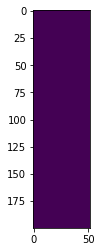

In [45]:
import matplotlib.pyplot as plt
plt.imshow(noise[0,:])
print(noise[0,:])

In [ ]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
[loss, accuracy] = model.evaluate(X_valid, Y_valid)

Y_valid_predict = model.predict(X_valid)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.argmax(Y_valid_predict, axis=1), np.argmax(Y_valid, axis=1))
plot_confusion_matrix(cm = matrix,
                      target_names = ['Raise_arm', 'Run', 'Bow', 'Walk'],
                      title        = "Confusion Matrix")

In [ ]:
print(X_valid.dtype)

# Generate the Universial Perturbation Through Deepfool

In [ ]:

from art.classifiers import KerasClassifier
from art.attacks import TargetedUniversalPerturbation
from art.utils import random_sphere

# build targeted UAP
classifier = KerasClassifier(model=model)
adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.000001,
    attacker_params={'targeted':True, 'eps':0.006},
    max_iter=10,
    eps=5.5,
    norm=2)


# set target label
target = 1
y_train_adv_tar = np.zeros(Y_train.shape)
for i in range(Y_train.shape[0]):
    y_train_adv_tar[i, target] = 1.0

# generate noise
_ = adv_crafter.generate(X_train, y=y_train_adv_tar)



In [ ]:
print(type(adv_crafter.noise))
# noise = adv_crafter.noise[0,:]

# X_train_adv = X_train + noise
# X_valid_adv = X_valid + noise

In [ ]:
[loss, accuracy] = model.evaluate(X_dirty, Y_dirty)

Y_dirty_predict = model.predict(X_dirty)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.argmax(Y_dirty, axis=1), np.argmax(Y_dirty_predict, axis=1))

plot_confusion_matrix(cm = matrix,
                      target_names = ['Raise_arm', 'Run', 'Bow', 'Walk'],
                      title        = "Confusion Matrix")

In [ ]:
X_train, Y_train, num_classes = generate_dataset('./usrp_dataset2/training/')

norm_X = (X_train- mean)/std

[loss, accuracy] = model.evaluate(norm_X, Y_train)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
dirty_X, dirty_Y, num_classes = generate_dataset('./our_dataset/data/dirty')
print(len(dirty_Y))

model.evaluate(dirty_X, dirty_Y);

In [ ]:
model.predict(dirty_X)
x = model.predict(dirty_X)
print(np.argmax(x, axis=1))
print(np.argmax(dirty_Y, axis=1))

## Create the adversarial sample

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original CSI resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the input.

In [ ]:
import tensorflow as tf
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_images, input_labels):

  input_image = tf.convert_to_tensor(input_images, dtype=tf.float32)
  input_label = tf.convert_to_tensor(input_labels, dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)

  fgm_grad= gradient / tf.norm(gradient, ord=2)

  return signed_grad, fgm_grad

# Get the original CSI.

In [ ]:
import matplotlib.pyplot as plt
original_csis = X_valid
original_targets = Y_valid

In [ ]:
perturbations1, perturbations2 = create_adversarial_pattern(original_csis, original_targets)

In [ ]:
def accuracy(x_valid, y_valid):
    y_pred = model.predict(x_valid)
    y_predict = np.argmax(y_pred, axis=1)
    y_valid_one = np.argmax(y_valid, axis=1)
    accuracy = round(sum([y_ == y for y_, y in zip(y_predict, y_valid_one)])/len(y_valid_one) * 100,2)
    print("accuracy: {}%".format(accuracy))
    return accuracy

In [ ]:
epss = [];
adv_accuracys = [];
clean_accuracys = [];
for eps in range(0, 11):
    adv_x = original_csis
    adv_x = adv_x + eps * perturbations1
    # compute accuracy
    acc = accuracy(adv_x, original_targets)
    epss.append(eps/10)
    adv_accuracys.append(acc)
    clean_accuracys.append(98.46)
    print("eps: {} ---> adv_acc:{}%".format(eps, acc))

In [ ]:
clean1 = plt.plot(epss, clean_accuracys, marker = 'v', linestyle = 'solid', label='Clean')
adv1 = plt.plot(epss, adv_accuracys, marker = 'o', linestyle = 'solid', label='FGM')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy(%)")
plt.show()